In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs

In [2]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [3]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)
    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')
    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )
    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)
    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")
        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 
        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")
    fig.tight_layout()
    
    return fig

In [4]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [6]:
df= pd.read_csv("Data/opsd_germany_daily.csv")
df

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.18400,NaN,NaN,NaN
1,2006-01-02,1380.52100,NaN,NaN,NaN
2,2006-01-03,1442.53300,NaN,NaN,NaN
3,2006-01-04,1457.21700,NaN,NaN,NaN
4,2006-01-05,1477.13100,NaN,NaN,NaN
...,...,...,...,...,...
4378,2017-12-27,1263.94091,394.507,16.530,411.037
4379,2017-12-28,1299.86398,506.424,14.162,520.586
4380,2017-12-29,1295.08753,584.277,29.854,614.131
4381,2017-12-30,1215.44897,721.247,7.467,728.714


In [7]:
df['Date']= pd.to_datetime(df['Date'])
df= df.set_index('Date')
df

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.18400,NaN,NaN,NaN
2006-01-02,1380.52100,NaN,NaN,NaN
2006-01-03,1442.53300,NaN,NaN,NaN
2006-01-04,1457.21700,NaN,NaN,NaN
2006-01-05,1477.13100,NaN,NaN,NaN
...,...,...,...,...
2017-12-27,1263.94091,394.507,16.530,411.037
2017-12-28,1299.86398,506.424,14.162,520.586
2017-12-29,1295.08753,584.277,29.854,614.131


In [8]:
df= df.resample("M").mean()
df

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-31,1461.442065,NaN,NaN,NaN
2006-02-28,1467.106893,NaN,NaN,NaN
2006-03-31,1418.649161,NaN,NaN,NaN
2006-04-30,1275.058900,NaN,NaN,NaN
2006-05-31,1253.488484,NaN,NaN,NaN
...,...,...,...,...
2017-08-31,1291.283022,177.412839,148.477677,325.890516
2017-09-30,1335.952031,209.591000,102.643033,312.234033
2017-10-31,1366.297385,402.583774,68.727645,471.311419


In [12]:
ts = df['Consumption']

In [13]:
ts.isna().sum()

0

In [10]:
ts= ts.dropna()

<Axes: xlabel='Date'>

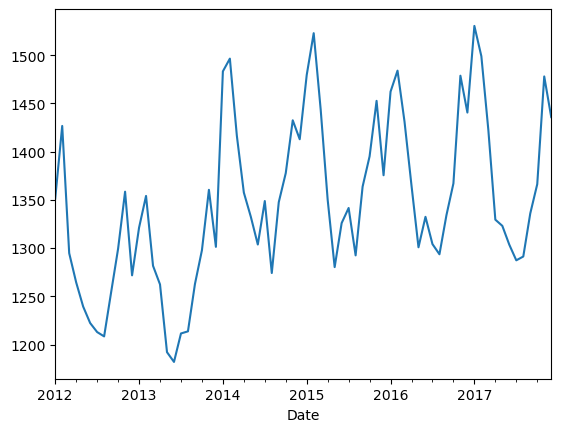

In [14]:
ts.plot()

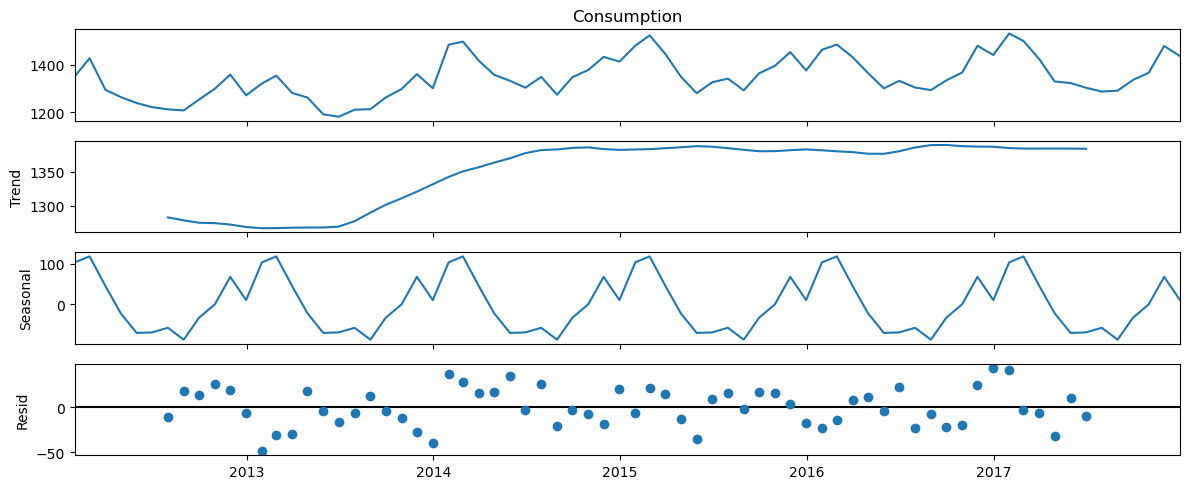

In [15]:
# check for seasonality 

decomp = tsa.seasonal_decompose(ts)
fig = decomp.plot()
fig.set_size_inches(12,5)
fig.tight_layout()

In [16]:
# How big is the seasonal component
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()

# How big is the seasonal component relative to the time series?
print(f"The seasonal component is {seasonal_delta} which is ~{seasonal_delta/(ts.max()-ts.min()) * 100 :.2f}% of the variation in time series.")

The seasonal component is 206.29843113917568 which is ~59.22% of the variation in time series.


In [17]:
# check for nonseasonal differencing
ndiffs(ts)

1

In [18]:
# Check for seasonal differcing
nsdiffs(ts, m = 12)

0

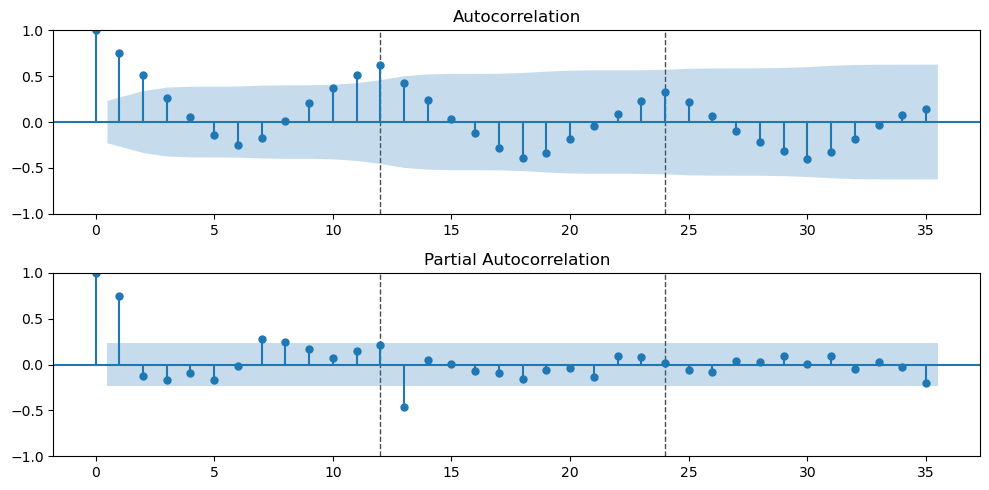

In [20]:
# We can use our function to highlight the seasonal lags by adding the arguments
plot_acf_pacf(ts, annotate_seas=True, m = 12, nlags = 35);

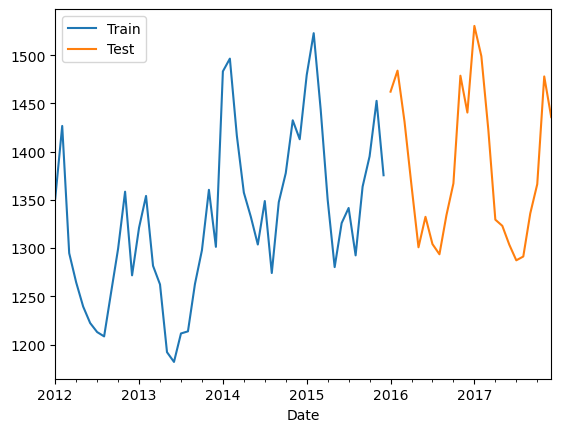

In [21]:
# tts so test size is 24 lags
test_lags = 24 
train, test = train_test_split(ts, test_size= test_lags)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

In [22]:
# IGNORE THE SEASONAL COMPONENT AND RUN AN ARIMA

# Try a nonseasonal model
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 0  # nonseasonal differencing
q = 0  # nonseasonal MA

arima = tsa.ARIMA(train, order = (p,d,q)).fit()

# Obtain summary
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Consumption   No. Observations:                   48
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -262.042
Date:                Thu, 08 Feb 2024   AIC                            530.083
Time:                        06:03:19   BIC                            535.697
Sample:                    01-31-2012   HQIC                           532.205
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1333.6453     32.667     40.825      0.000    1269.619    1397.672
ar.L1          0.7313      0.114      6.419      0.000       0.508       0.955
sigma2      3179.8382    678.430      4.687      0.000    1850.140    4509.536
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):                 2.03
Prob(Q):                              0.60   Prob(JB):                         0.36
Heteroskedasticity (H):               1.12   Skew:                             0.50
Prob(H) (two-sided):                  0.82   Kurtosis:                         3.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

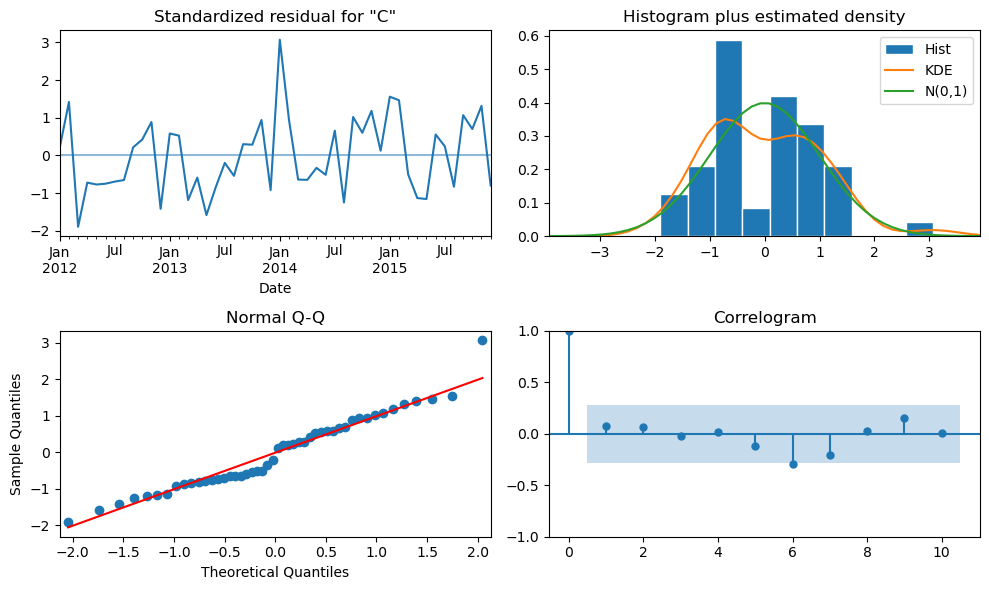

In [23]:
# Obtain diagnostic plots
fig = arima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 66.717
- MSE = 7,557.185
- RMSE = 86.932
- R^2 = -0.304
- MAPE = 4.65%


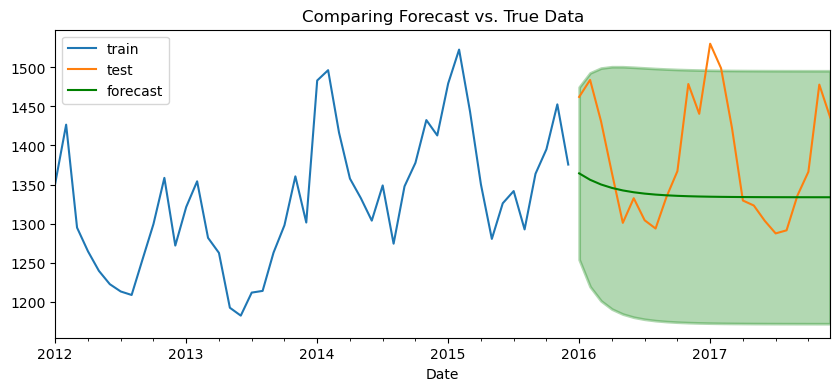

In [24]:
# Obtain forecast as a dataframe with confidence intervals
forecast_df = arima.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

In [25]:
# INCLUDE A SEASONAL COMPONENT

# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 0  # nonseasonal differencing
q = 0  # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
sarima.summary()

/Users/sofiawang/anaconda3/envs/dojo-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        Consumption   No. Observations:                   48
Model:             ARIMA(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                -246.573
Date:                            Thu, 08 Feb 2024   AIC                            503.146
Time:                                    06:04:01   BIC                            512.502
Sample:                                01-31-2012   HQIC                           506.682
                                     - 12-31-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1330.2595    156.811      8.483      0.000    1022.916    1637.603
ar.L1          0.8367      0.104      8.059      0.000       0.633       1.040
ar.S.L12       0.9622      0.089     10.833      0.000       0.788       1.136
ma.S.L12      -0.5930      0.464     -1.279      0.201      -1.502       0.316
sigma2      1183.0802    340.159      3.478      0.001     516.381    1849.779
===================================================================================
Ljung-Box (L1) (Q):                   1.38   Jarque-Bera (JB):                21.06
Prob(Q):                              0.24   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                             0.82
Prob(H) (two-sided):                  0.98   Kurtosis:                         5.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

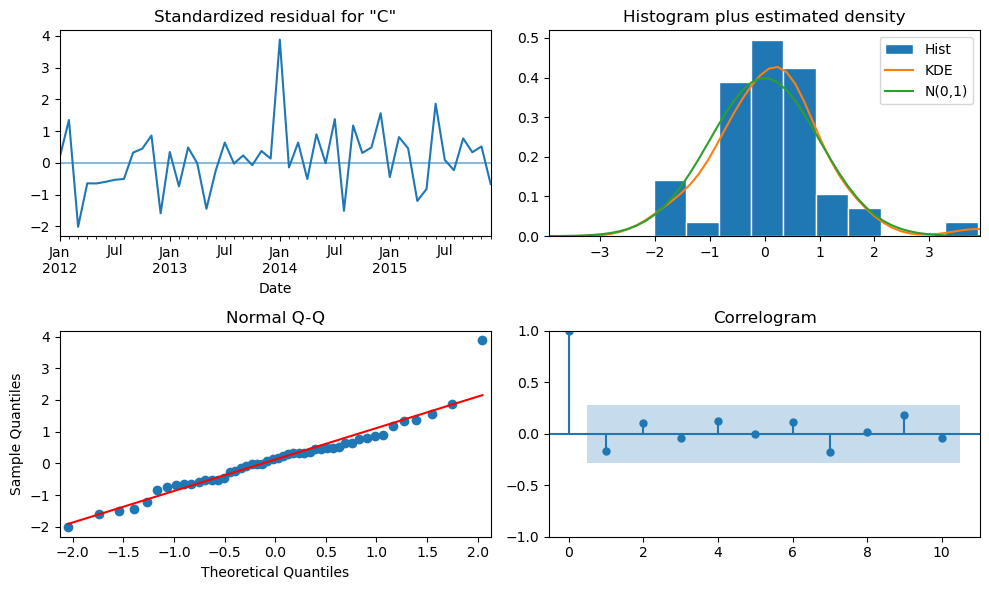

In [26]:
# Obtain diagnostic plots
fig = sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 29.483
- MSE = 1,667.996
- RMSE = 40.841
- R^2 = 0.712
- MAPE = 2.07%


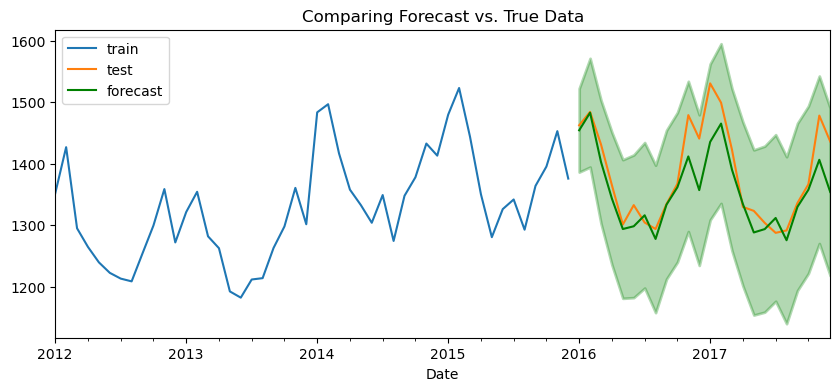

In [27]:
# Obtain forecast as a dataframe with confidence intervals
forecast_df = sarima.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

In [28]:
# GRIDSEARCH ASSIGNMENT 

# using autoARIMA

import pmdarima as pm

# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima(
    train,
    seasonal=True,  
    m=12,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=368.511, Time=1.24 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=403.585, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=362.816, Time=0.81 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.95 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=410.925, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=377.249, Time=0.07 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=364.750, Time=1.15 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.79 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.01 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=369.974, Time=0.18 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=364.305, Time=0.32 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=364.183, Time=0.66 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=365.761, Time=0.59 sec
 ARIMA(2,0,1)(1,1,0)[12] intercept   : AIC=366.17

In [29]:
# the auto_arima will store our best nonseasonal and seasonal orders separtely
print(auto_model.order)
print(auto_model.seasonal_order)

(1, 0, 0)
(1, 1, 0, 12)


In [30]:
# Orders for non seasonal components
p = 1 # nonseasonal AR
d = 0  # nonseasonal differencing
q = 1 # nonseasonal MA

# Orders for seasonal components
P = 1 # Seasonal AR
D = 0  # Seasonal differencing
Q = 0  # Seasonal MA
m = 12 # Seasonal period

auto_sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Or instead of manually defining the orders, you can obtain them programmatically
# auto_sarima = tsa.ARIMA(train, order = auto_model.order, seasonal_order = auto_model.seasonal_order)

# Obtain model summary
auto_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                       Consumption   No. Observations:                   48
Model:             ARIMA(1, 0, 1)x(1, 0, [], 12)   Log Likelihood                -248.378
Date:                           Thu, 08 Feb 2024   AIC                            506.755
Time:                                   06:05:39   BIC                            516.111
Sample:                               01-31-2012   HQIC                           510.291
                                    - 12-31-2015                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1330.3018     93.497     14.228      0.000    1147.051    1513.553
ar.L1          0.8227      0.130      6.342      0.000       0.568       1.077
ma.L1         -0.1349      0.201     -0.671      0.502      -0.529       0.259
ar.S.L12       0.7454      0.117      6.396      0.000       0.517       0.974
sigma2      1460.1615    222.397      6.566      0.000    1024.272    1896.051
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                19.89
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                             0.79
Prob(H) (two-sided):                  0.93   Kurtosis:                         5.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

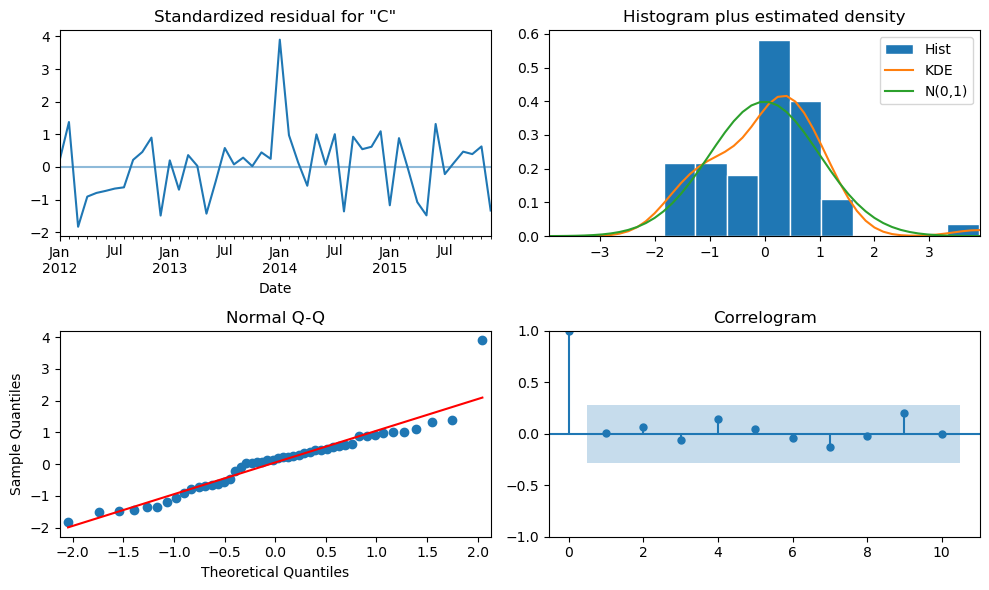

In [31]:
# Obtain diagnostic plots
fig = auto_sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 34.367
- MSE = 2,101.436
- RMSE = 45.841
- R^2 = 0.637
- MAPE = 2.41%


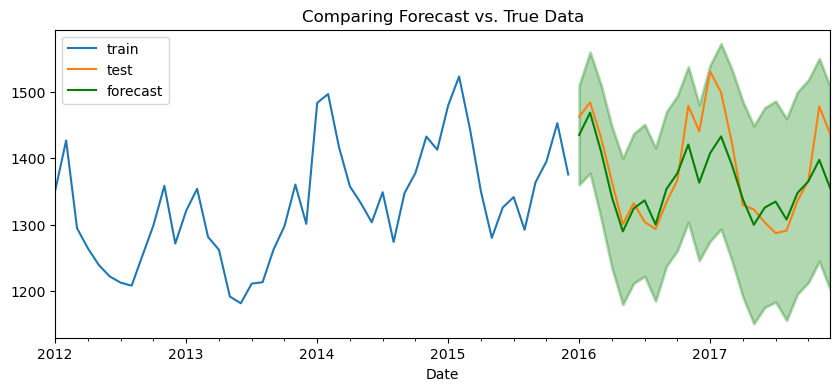

In [32]:
# Obtain summary of forecast as dataframe
forecast_df = auto_sarima.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df)
# Obtain metrics
regression_metrics_ts(test, forecast_df["mean"])

The (1,0,1)(1,0,0,12) model was best in performance of regression metrics.